In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from tqdm import tqdm
from experiment_mnist import *

/home/sergei/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


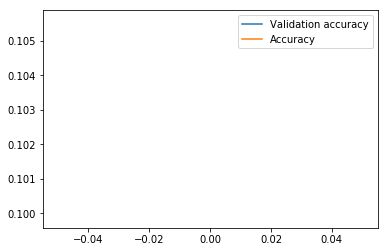

Creating network for 784-dimensional input and 10-dimensional output, with 2 hidden layers


In [2]:
P = 0.123 # 0.001 gives 170%. Why?
KLips = 1
experiment = MNISTExperiment(N = [10, 10], P = P, epochs = 1, KLips = KLips, activation = 'relu', do_print = True)

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


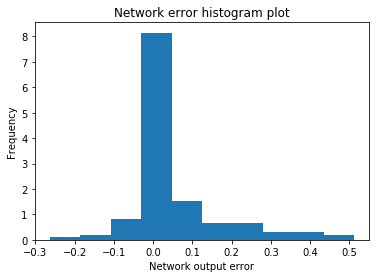

Error; maximal over inputs, average over dropout:
True values array mean: -0.187188 variance 0.140824
Experiment 0.167284 Std 0.186306
Equation   2.521945 Std 3.541805
Tightness  6.6% Std 5.3%


array([[ 0.45394886, -0.45394886, -0.45394886, -0.45394886,  0.45394886,
        -0.45394886, -0.45394886, -0.45394886,  0.45394886, -0.45394886],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [3]:
experiment.run(inputs = 1)
experiment.get_mean_std_error()
experiment.dEDelta_dW(1, 2)

In [4]:
from helpers import *

In [5]:
# probability per layer (constant here)
p_layer = 0.1

# maximal value per layer (constant here)
C_layer = 1.0

# Lipschitz coefficient
KLips = 1

# array of Erf for layers
errors = {-1: 0}

# regularization strength
lambda_ = 0.01

def get_kernel_reg(layer):
    """ Get a Erf regularizer for layer"""
    
    def kernel_reg(w, layer = layer):
        """ Regularizer for a layer """
        # Maximal 1-norm over output neuron
        wnorm1 = K.max(K.sum(K.abs(w), axis = 0))
        
        # error (induction)
        error = (p_layer * C_layer + KLips * (1 - p_layer) * errors[layer - 1]) * wnorm1
        
        # saving the error for the next call
        errors[layer] = error
        
        # returning the error scaled
        return error * lambda_
    
    # returning the function
    return kernel_reg

In [6]:
def create_random_weight_model(Ns, KLips, func = 'sigmoid'):
  """ Create some simple network with given dropout prob, weights and Lipschitz coefficient for sigmoid """
  
  # creating model
  model = Sequential()

  # adding layers
  for i in range(len(Ns) - 1):
    # is last layer (with output)?
    is_last = i + 2 == len(Ns)
    
    # adding dense layer with sigmoid for hidden and linear for last layer
    model.add(Dense(Ns[i + 1], input_shape = (Ns[i], ),
                    kernel_initializer = 'random_normal',
                    activation = 'linear' if is_last else get_custom_activation(KLips, func),
                    bias_initializer = 'random_normal',
                    kernel_regularizer = get_kernel_reg(i)))

  model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', 'mean_squared_error'])

  model.summary()
  return model

In [7]:
model = create_random_weight_model([28**2,100,100,100,10], 1.0, func = 'relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(experiment.x_train, experiment.y_train, epochs=5, verbose = True)

Epoch 1/5
60000/60000 [==============================] - 21s 347us/step - loss: 0.5954 - acc: 0.8096 - mean_squared_error: 0.0927
Epoch 2/5
60000/60000 [==============================] - 26s 427us/step - loss: 0.0673 - acc: 0.9413 - mean_squared_error: 0.0139
Epoch 3/5
60000/60000 [==============================] - 18s 306us/step - loss: 0.0299 - acc: 0.9513 - mean_squared_error: 0.0116
Epoch 4/5
60000/60000 [==============================] - 20s 336us/step - loss: 0.0227 - acc: 0.9568 - mean_squared_error: 0.0104
Epoch 5/5
60000/60000 [==============================] - 19s 316us/step - loss: 0.0204 - acc: 0.9597 - mean_squared_error: 0.0097
